<a class="anchor" id="0"></a>

# FE & EDA with 3D and abnormals filtering of Used Cars Dataset

## An example of effective filtering of anomal values in prediction problems

**[Used Cars Dataset](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)**

**Graphs were constructed that showed the presence of anomalies for a number of features**

**It is suggested to look for the anomalies of the smallest and largest values with the help of quantiles and select filters of values**

Technology for feature importance building from the my notebooks:
* [Used Cars - FE & EDA with 3D, abnormals filter](https://www.kaggle.com/code/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter)
* [NFL feature importance - xgb, lgbm, linreg](https://www.kaggle.com/vbmokin/nfl-feature-importance-xgb-lgbm-linreg)
* [Feature importance - xgb, lgbm, logreg, linreg](https://www.kaggle.com/vbmokin/feature-importance-xgb-lgbm-logreg-linreg)

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download dataset](#2)
1. [Preparing to analysis](#3)
1. [EDA](#4)
1. [Modeling and prediction](#5)
    -  [Linear Regression](#5.3)
    -  [Random Forest](#5.1)
1. [Feature Importance Analysis](#6)
    -  [Feature importance for Linear Regression](#6.1)
    -  [Feature importance for Random Forest](#6.2)
    -  [SHAP : Feature importance for Random Forest](#6.3)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
import numpy as np 
import pandas as pd 
import gc

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import shap

pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

## 2. Download dataset <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [2]:
df = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv')
df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

## 3. Preparing to analysis <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [4]:
# Drop non-interesting features
drop_columns = ['id', 'url', 'region', 'region_url', 'condition', 'drive',
                'size', 'type', 'paint_color', 'title_status', 'VIN', 'image_url', 
                 'county','description', 'state', 'lat','long', 'posting_date']
df = df.drop(columns = drop_columns).dropna().reset_index(drop=True)
df.head(5)

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission
0,33590,2014.0,gmc,sierra 1500 crew cab slt,8 cylinders,gas,57923.0,other
1,22590,2010.0,chevrolet,silverado 1500,8 cylinders,gas,71229.0,other
2,39590,2020.0,chevrolet,silverado 1500 crew,8 cylinders,gas,19160.0,other
3,30990,2017.0,toyota,tundra double cab sr,8 cylinders,gas,41124.0,other
4,15000,2013.0,ford,f-150 xlt,6 cylinders,gas,128000.0,automatic


In [5]:
# from the my kernel: https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [6]:
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
df = reduce_mem_usage(df)
gc.collect()

Mem. usage decreased to  4.47 Mb (68.7% reduction)


0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234270 entries, 0 to 234269
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         234270 non-null  int64  
 1   year          234270 non-null  float16
 2   manufacturer  234270 non-null  int8   
 3   model         234270 non-null  int16  
 4   cylinders     234270 non-null  int8   
 5   fuel          234270 non-null  int8   
 6   odometer      234270 non-null  float32
 7   transmission  234270 non-null  int8   
dtypes: float16(1), float32(1), int16(1), int64(1), int8(4)
memory usage: 4.5 MB


## 4. EDA <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [9]:
df

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission
0,33590,2014.0,14,13857,6,2,57923.0,2
1,22590,2010.0,7,14136,6,2,71229.0,2
2,39590,2020.0,7,14157,6,2,19160.0,2
3,30990,2017.0,38,16374,6,2,41124.0,2
4,15000,2013.0,13,7118,5,2,128000.0,0
...,...,...,...,...,...,...,...,...
234265,32990,2016.0,18,12518,6,2,55612.0,0
234266,0,2010.0,38,16591,5,2,155000.0,0
234267,33590,2018.0,23,9270,5,2,30814.0,0
234268,23590,2019.0,30,10720,5,2,32226.0,2


In [10]:
df.describe()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission
count,2.342700e+05,234270.0,234270.000000,234270.000000,234270.000000,234270.000000,2.342700e+05,234270.000000
mean,5.492244e+04,NaN,18.591228,9099.965800,4.623298,1.937764,1.032303e+05,0.283545
std,1.116684e+07,NaN,11.222873,4999.577509,1.261504,0.599636,1.963413e+05,0.651563
min,0.000000e+00,1900.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,5.555000e+03,2008.0,10.000000,4860.000000,3.000000,2.000000,4.726700e+04,0.000000
50%,1.200000e+04,2013.0,14.000000,9149.000000,5.000000,2.000000,9.431350e+04,0.000000
75%,2.499000e+04,2016.0,29.000000,13814.000000,6.000000,2.000000,1.398552e+05,0.000000
max,3.736929e+09,2022.0,40.000000,17634.000000,7.000000,4.000000,1.000000e+07,2.000000


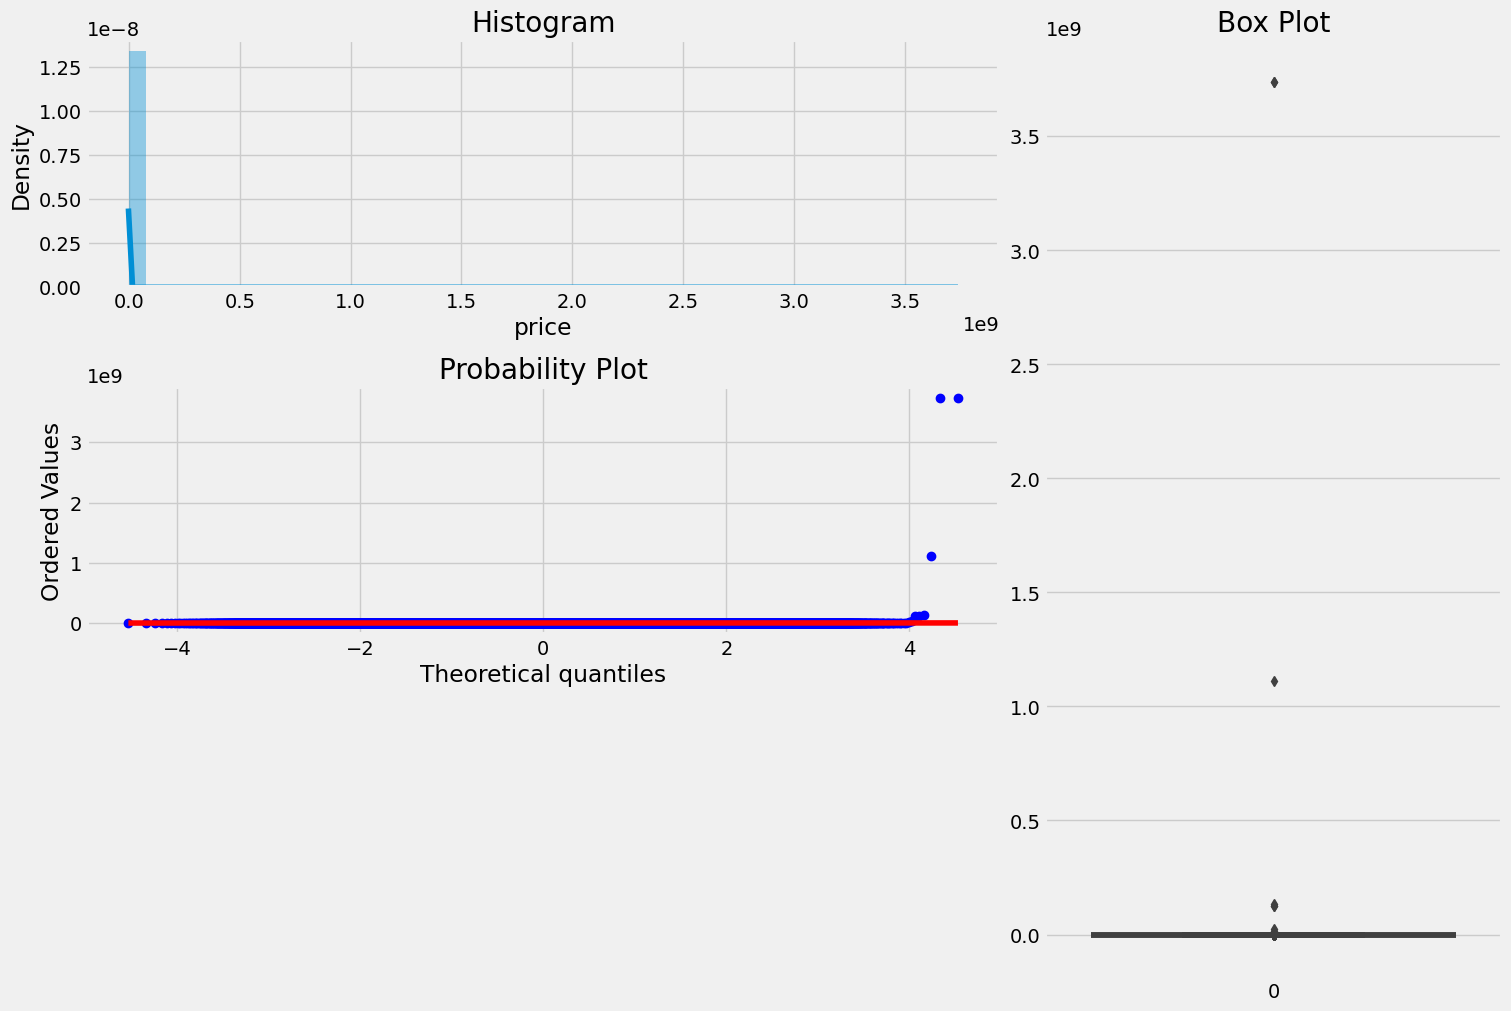

In [11]:
#Thanks to https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(df, 'price')

In [12]:
def plot3D(df):
    # Drawing 3D plot
    # Thanks to https://towardsdatascience.com/an-easy-introduction-to-3d-plotting-with-matplotlib-801561999725

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection="3d")

    z_points = df['price']
    x_points = df['odometer']
    y_points = df['year']
    ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

    ax.set_xlabel('odometer')
    ax.set_ylabel('year')
    ax.set_zlabel('price')

    plt.show()

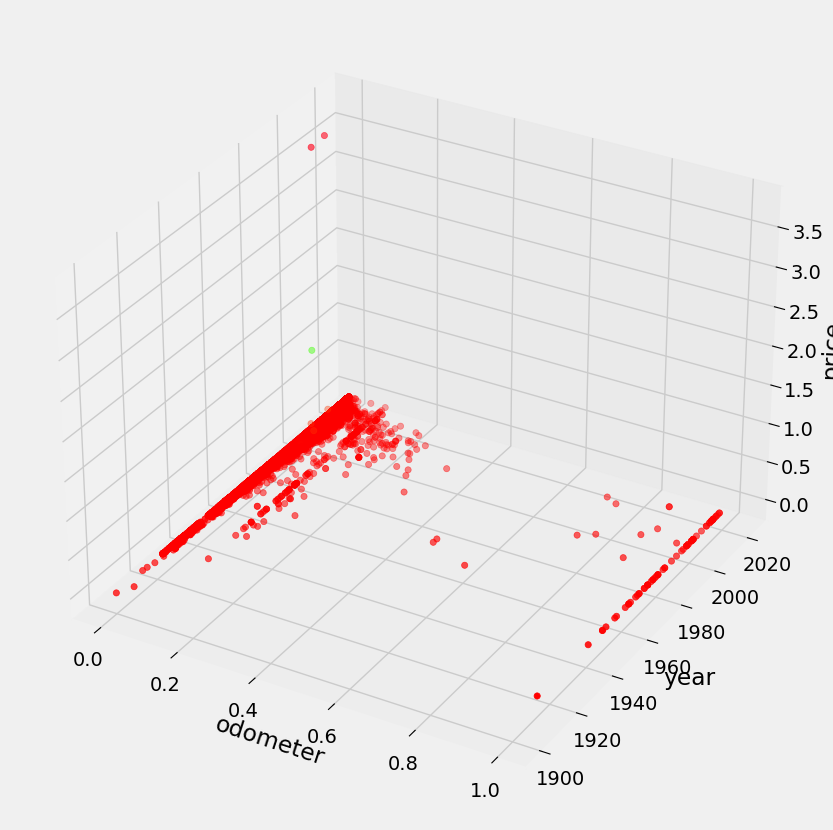

In [13]:
plot3D(df)

<Axes: ylabel='price'>

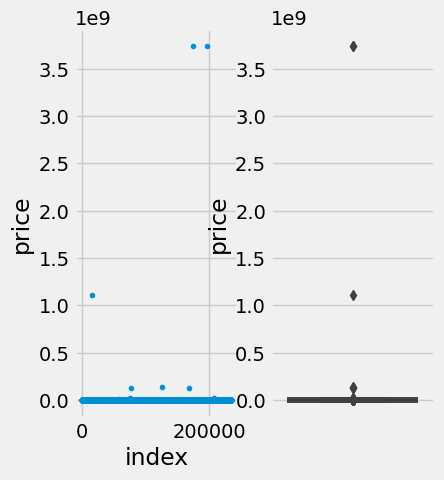

In [14]:
# Boxplot drawing
y = np.array(df.price)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('price');plt.xlabel('index');
plt.subplot(132)
sns.boxplot(y=df.price)

## Selection the conditions for effective filter of abnormal values

Check percentiles 5%, 10% and 90%, 95%

In [15]:
# Statictics
df.describe(percentiles = [.05,.1, .9,.95])

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission
count,2.342700e+05,234270.0,234270.000000,234270.000000,234270.000000,234270.000000,2.342700e+05,234270.000000
mean,5.492244e+04,NaN,18.591228,9099.965800,4.623298,1.937764,1.032303e+05,0.283545
std,1.116684e+07,NaN,11.222873,4999.577509,1.261504,0.599636,1.963413e+05,0.651563
min,0.000000e+00,1900.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
5%,0.000000e+00,1998.0,4.000000,928.000000,3.000000,0.000000,1.049600e+04,0.000000
10%,1.250000e+03,2003.0,7.000000,2258.000000,3.000000,2.000000,2.059990e+04,0.000000
50%,1.200000e+04,2013.0,14.000000,9149.000000,5.000000,2.000000,9.431350e+04,0.000000
90%,3.649000e+04,2018.0,38.000000,15790.000000,6.000000,2.000000,1.812510e+05,2.000000
95%,4.199755e+04,2019.0,38.000000,16814.000000,6.000000,2.000000,2.080404e+05,2.000000
max,3.736929e+09,2022.0,40.000000,17634.000000,7.000000,4.000000,1.000000e+07,2.000000


In [16]:
# Manual filter: price (upper (10%) and lower (95%)), year (upper 10%) and odometer (lower 90%)
df = df[(df['price'] >= 1250.00) & (df['price'] < 41997.55) & (df['year'] >= 2003) & (df['odometer'] <= 208040.4)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170548 entries, 0 to 234269
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         170548 non-null  int64  
 1   year          170548 non-null  float16
 2   manufacturer  170548 non-null  int8   
 3   model         170548 non-null  int16  
 4   cylinders     170548 non-null  int8   
 5   fuel          170548 non-null  int8   
 6   odometer      170548 non-null  float32
 7   transmission  170548 non-null  int8   
dtypes: float16(1), float32(1), int16(1), int64(1), int8(4)
memory usage: 4.6 MB


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170548 entries, 0 to 234269
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         170548 non-null  int64  
 1   year          170548 non-null  float16
 2   manufacturer  170548 non-null  int8   
 3   model         170548 non-null  int16  
 4   cylinders     170548 non-null  int8   
 5   fuel          170548 non-null  int8   
 6   odometer      170548 non-null  float32
 7   transmission  170548 non-null  int8   
dtypes: float16(1), float32(1), int16(1), int64(1), int8(4)
memory usage: 4.6 MB


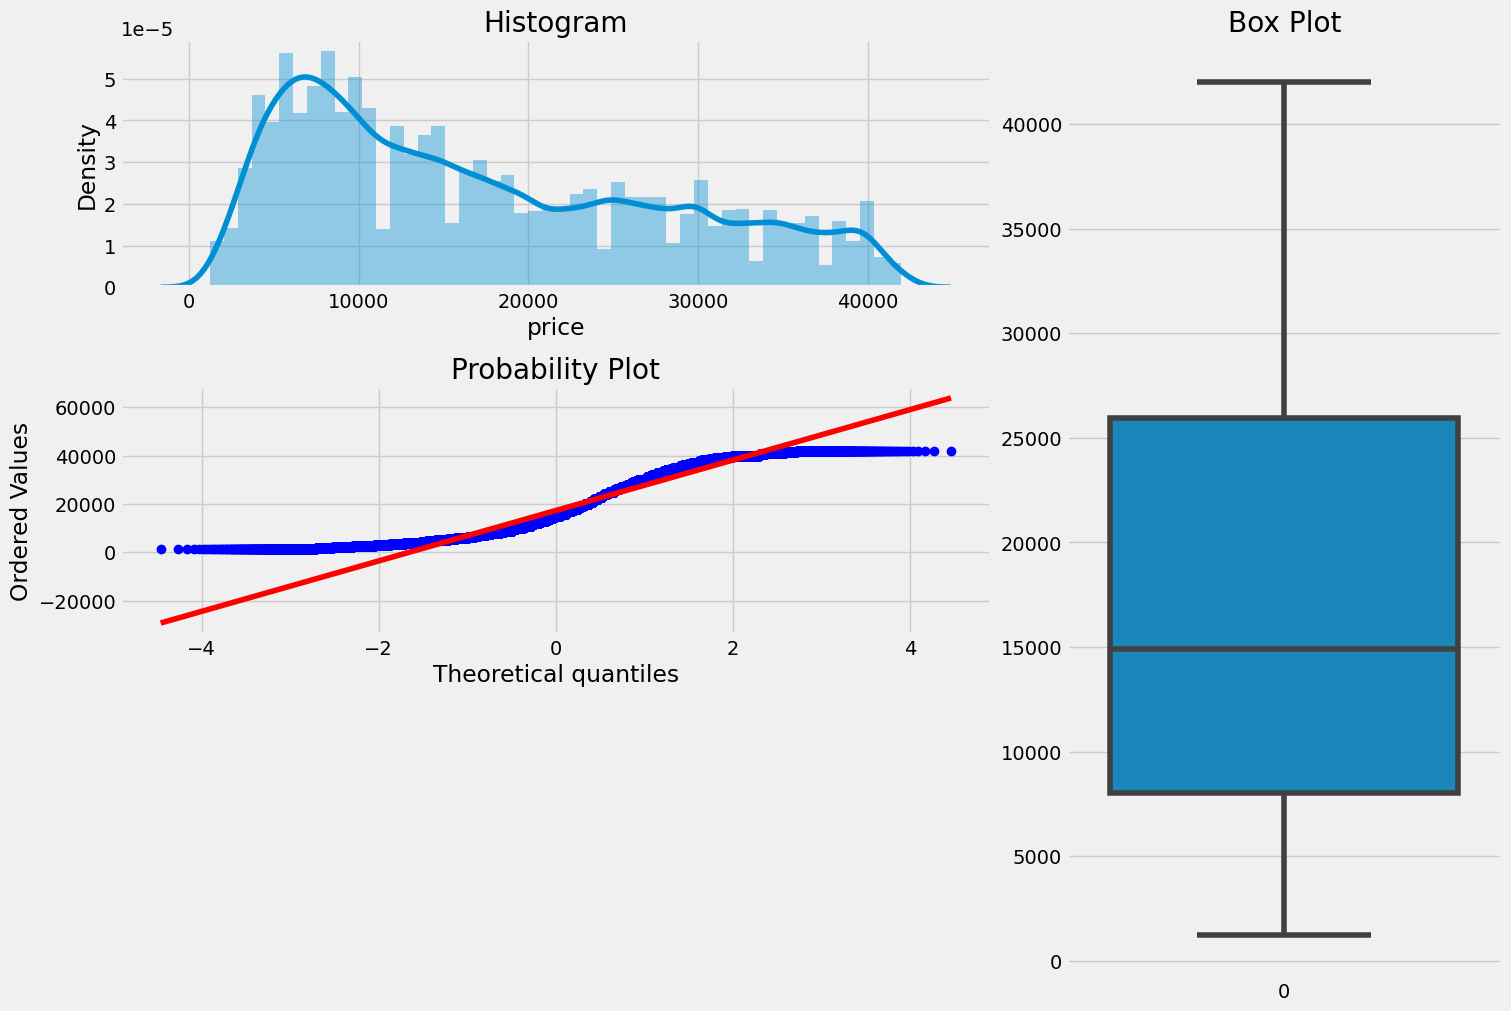

In [18]:
plotting_3_chart(df, 'price')

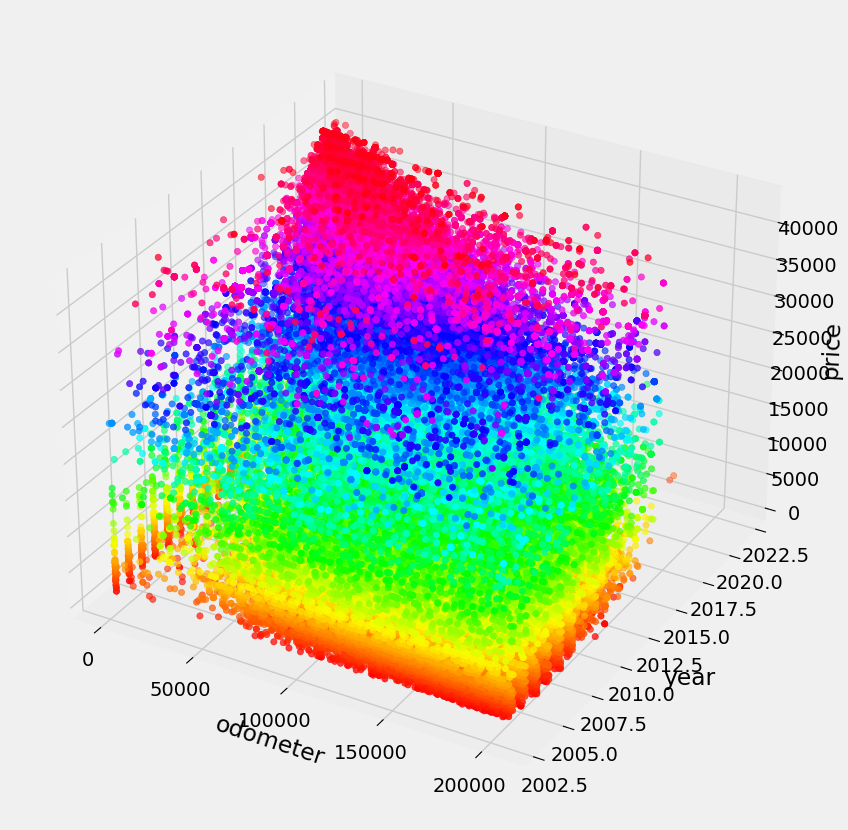

In [19]:
plot3D(df)

## 5. Modeling and prediction<a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

In [20]:
y = df.pop('price')

In [21]:
# Standartization
df = pd.DataFrame(
    preprocessing.StandardScaler().fit_transform(df),
    columns=df.columns,
    index=df.index
)

In [22]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [23]:
# Results of prediction
results = pd.DataFrame(columns = ['model', 'r2_train', 'r2_test'])

### 5.1 Random Forest <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

In [24]:
%%time
model_tuning = GridSearchCV(estimator=RandomForestRegressor(),
#                      param_grid={'n_estimators': [40, 50, 60, 80], 
#                                  'min_samples_split': [30, 40, 50, 60], 
#                                  'min_samples_leaf': [10, 12, 15, 20, 50],
#                                  'max_features': ['auto'], 
#                                  'max_depth': [3, 4, 5, 6, 7]                   
                     param_grid={'n_estimators': [50, 80], 
                                 'min_samples_leaf': [10, 20, 50],
                                 'max_depth': [5, 6, 7]                   
                                 })
model_tuning.fit(X_train, y_train)
best_params = model_tuning.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 80}
CPU times: user 13min 23s, sys: 367 ms, total: 13min 24s
Wall time: 13min 26s


In [25]:
# Model tuning with optimal parameters
model = RandomForestRegressor(**best_params)
#model = RandomForestRegressor(max_depth=5, n_estimators=50)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=10, n_estimators=80)

In [26]:
# Accuracy
# Train
train_predictions = model.predict(X_train)
r2_train = r2_score(y_train, train_predictions)

# Test
predictions = model.predict(X_test)
r2_test = r2_score(y_test, predictions)

# Save
results.loc[0,'model'] = 'RandomForestRegressor'
results.loc[0,'r2_train'] = r2_train
results.loc[0,'r2_test'] = r2_test

### 5.2 Linear Regression <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

In [27]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [28]:
# Accuracy
# Train
train_predictions = linreg.predict(X_train)
r2_train = r2_score(y_train, train_predictions)

# Test
predictions = linreg.predict(X_test)
r2_test = r2_score(y_test, predictions)

# Save
results.loc[1,'model'] = 'LinearRegression'
results.loc[1,'r2_train'] = r2_train
results.loc[1,'r2_test'] = r2_test

### 6. Results analysis <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

In [29]:
display(results)

,model,r2_train,r2_test
0,RandomForestRegressor,0.79711,0.798224
1,LinearRegression,0.685716,0.687569


#### 6.1. Feature importance for Linear Regression <a class="anchor" id="6.1"></a>

[Back to Table of Contents](#0.1)

In [30]:
# Feature importance for Linear Regression
coeff_linreg = pd.DataFrame(X_train.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
0,manufacturer,5214.647949
3,fuel,4347.631836
1,model,439.472412
2,cylinders,310.712738
4,odometer,-1254.317749
5,transmission,-3000.978516


#### 6.2. Feature importance for Random Forest <a class="anchor" id="6.2"></a>

[Back to Table of Contents](#0.1)

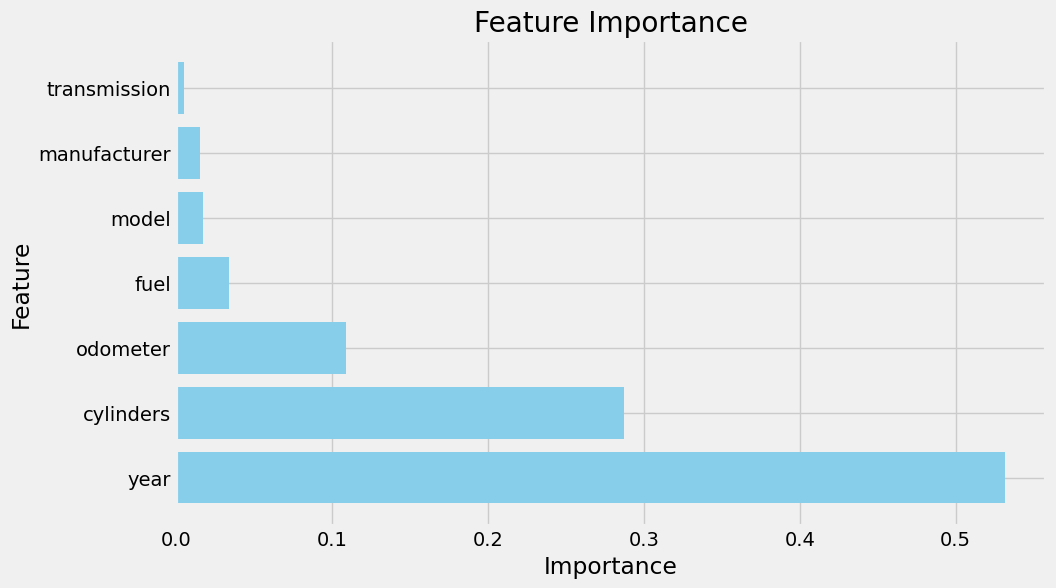

In [31]:
# Feature importance
importances = model.feature_importances_
feature_names = df.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### 6.3. SHAP : Feature importance for Random Forest <a class="anchor" id="6.3"></a>

[Back to Table of Contents](#0.1)

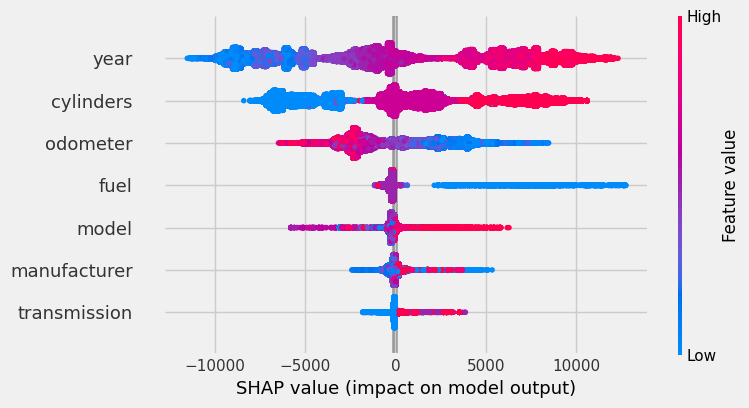

In [32]:
# SHAP summary_plot
explainer = shap.Explainer(model)
shap_values = explainer(df)
shap.summary_plot(shap_values, df)

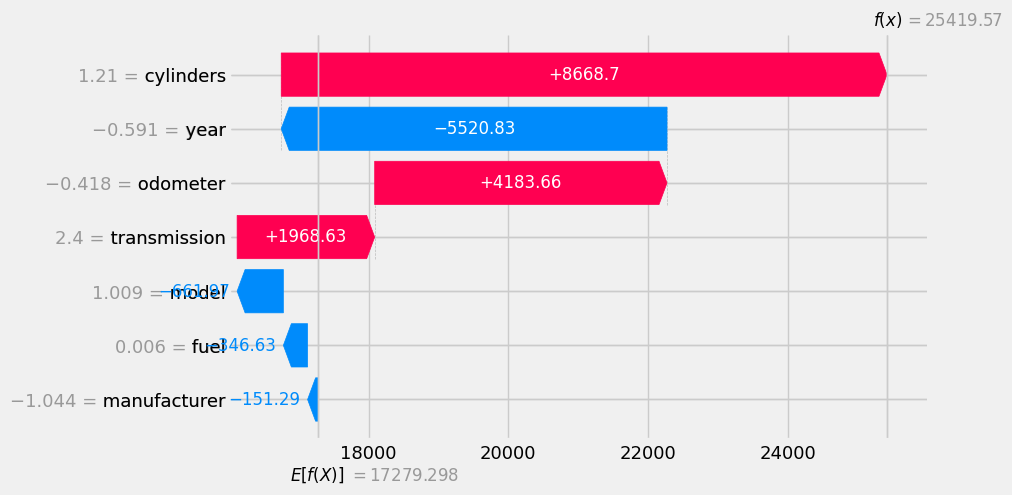

In [33]:
# SHAP Waterfall_plot
shap.waterfall_plot(shap_values[1])

In [34]:
# SHAP Force for row i
i = 4
shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test.iloc[i])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[i])

In [35]:
# # SHAP Force for all data
# shap.initjs()
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value, shap_values, X_test)

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)